# Week 2 - Improving Gradient Descent

Last week we learned about stochastic gradient descent, which allows us to estimate linear models in cases where the dataset is very large. As we will later see, it is also very useful for learning neural networks.

However, the vanilla stochastic gradient descent algorithm is not very efficient. You might have already guessed that a constant learning rate is not the best choice. Finding the best optimizer is an active area of research in the machine learning community. Today you will learn about two useful innovations: *momentum* and *rmsprop*.

The Deep Learning book by Goodfellow et al (2016) describes the issues surrounding optimization quite well. You can access this book online for free at [deeplearningbook.org](http://www.deeplearningbook.org). Optimization is discussed in [Chapter 8](http://www.deeplearningbook.org/contents/optimization.html), specifically a discussion of momentum can be found in section 8.3.2 and RMSProp in section 8.5.2.

# Import

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D #3d plots
from sklearn.metrics import r2_score

# Recap SGD

Last week we learned about the stochastic gradient descent algorithm.
Simply put the algorithm looks like this:

* Require: intialized weights $\mathbf{w}_0$
* Require: learning rate $\eta$
* For $i$ in iterations:
    * Sample a batch from the training set: $\mathbf{x, y}$
    * Estimate the gradient for this batch at the current weights: $\frac{dE}{d\mathbf{w}_{i}}$
    * Update the weights: $\mathbf{w}_{i+1} = \mathbf{w}_i - \eta * \frac{dE}{d\mathbf{w}_{i}}$
    
Below we do a quick recap:

In [2]:
# load the previous weeks functions as a module
from urllib.request import urlretrieve 
url = 'https://www.cjbs.net/users/yihe/storage/mle/week1.py'
urlretrieve(url,'week1.py')
from week1 import (generate_dataset,gaussian_basis_function, gaussian_basis_transformation,lr_sgd)

In [3]:
# Create dataset (t=2+1.25x+4*sin(4*x)+epsilon, epsilon~N(0,1))
n_ex = 400
sigma_ex = 1
x_ex, t_ex = generate_dataset(n_ex,sigma_ex)
# today we work with a smaller dataset to speed up the learning process in class
x_ex = x_ex[:100]
t_ex  = t_ex[:100]

# Make gaussian basis tranformation features
gbf = gaussian_basis_transformation(x_ex,3,scale='auto')
phi_ex = np.column_stack((np.ones(len(x_ex)),x_ex,gbf))

Optimal weights: [-298.71314484   -6.82434957  295.67131833  -62.84609573  314.8764468 ]


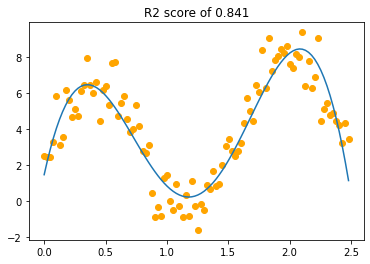

In [4]:
# Check optimal score with OLS:
w_ols = np.linalg.inv(phi_ex.T @ phi_ex) @ (phi_ex.T @t_ex)
r2 = r2_score(t_ex,phi_ex@w_ols)
print(f'Optimal weights: {w_ols}')

plt.scatter(x_ex,t_ex,c='orange')
plt.plot(x_ex,phi_ex@w_ols)
plt.title(f'R2 score of {r2:.3f}')
plt.show()

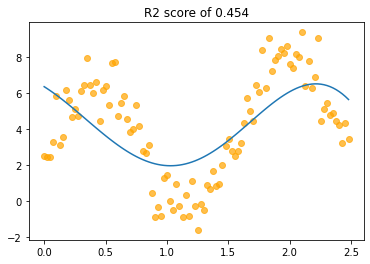

In [5]:
# Estimate with stochastic gradient descent
weights, gradients, costs  = lr_sgd(phi=phi_ex,
                                    t=t_ex,
                                    eta=0.001,
                                    batch_size=100,
                                    epochs=int(1e5), 
                                    verbose=False)

w = weights[-1]
# Make final prediction
y_ex = phi_ex@w
# plot first 1000 observations
plt.scatter(x_ex,t_ex,c='orange',alpha=0.7)
plt.plot(x_ex,y_ex)
r2 = r2_score(t_ex,y_ex)
plt.title(f'R2 score of {r2:.3f}')
plt.show()

**Conclusion: After 100,000 epochs we still are not close to the global minimum. Lets see what we can do to speed this up**

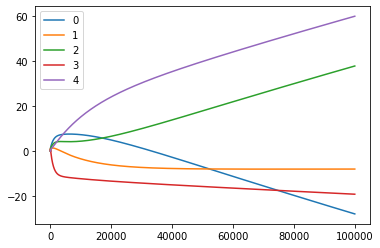

In [6]:
# Plot parameters over iterations
for i in range(weights.shape[1]):
    plt.plot(weights[:,i],label=f'{i}')
plt.legend()
plt.show()

**Conclusion: some parameters are learned quicker than others**

# Agenda for today

Today you will learn about two innovations to the algorithm that speed up its learning.

1. Momentum: an adjustment to the gradient estimates 
2. RMSProp: an adjustment to the learning rates

# Momentum

## Intuition

Section 8.3.2. of Goodfellow et al (2016)'s deep learning book describes the motivation and implementation of momentum very well: 

> While stochastic gradient descent remains a very popular optimization strategy, learning with it can sometimes be slow. The method of momentum (Polyak 1964), is designed to accelerate learning, especially in the face of high curvature, small but consistent gradients, or noisy gradients. The momentum algorithm accumulates an exponentially decaying moving average of past gradients and continues to move in their direction. The effect of momentum is illustrated in Fig.8.5

Intuitively the exponentially decaying moving average (EDMA) of past gradients can be interpreted as *velocity*. While vanilla SGD can be seen as a person walking down a hill step by step, instead momentum can be seen as a ball rolling down a hill. As the ball moves in a direction it picks up speed that is maintained in the future.

Figure 8.5 of Goodfellow et al (2016).:

![Momentum](https://www.cjbs.net/users/yihe/storage/mle/fig85_dl_book.png)



**Algorithm -- SGD With Momentum:**
* Require: intialized weights $\mathbf{w}_0$
* Require: learning rate $\eta$
* Require: momentum parameter $m$
* For $i$ in iterations:
    * Sample a batch from the training set: $\mathbf{x, y}$
    * Estimate the gradient for this batch at the current weights: $\frac{dE}{d\mathbf{w}_{i}}$
    * **NEW:** Compute velocity update: $v_i = m*v_{i-1} + (1-m)*\frac{dE}{d\mathbf{w}_{i}}$
    * Update the weights: $\mathbf{w}_{i+1} = \mathbf{w}_i - \eta * v_i$


## Implementation

In [7]:
#Exercise: Add momentum to sgd
def lr_gd_mom(phi,t, eta, mom, batch_size, epochs, weights_only=False, verbose=False):
    """    
    Purpose:
        Stochastic Gradient Descent with momentum
    Inputs:
        phi        (n,k) matrix, design matrix
        t          (n,) vector, target variable
        eta        double, learning rate
        mom        double, momentum parameter
        batch_size integer, length of subset of data in one batch
        epochs     integer, number of epochs, that is the number of runs through the entire dataset
        weights_only: boolean, if True then only the last, presumably best, weights are returned
        verbose:      boolean, if True then print cost and r squared at end of each epoch
    Output:
    if weights_only=True:
        weights    (k,) vector, last weights
    
    if weights_only=False:
        weights    (total_iters,k) matrix, weight values for each epoch
        gradients  (total_iters,k) matrix, gradient values for each epoch
        costs      (total_iters,) vector, loss values for each epoch
    """
    # intialize
    n = t.shape[0]
    w = np.zeros(phi.shape[1])
    edma_dEdw = None # exponentially decaying moving average of gradients  
    
    # calc iters per epoch given a batch size
    iters_per_epoch = (n-1)//batch_size + 1
    total_iters = epochs * iters_per_epoch
    
    # result arrays
    if not weights_only:
        weights = np.zeros((total_iters,phi.shape[1]))
        gradients = np.zeros((total_iters,phi.shape[1]))
        costs = np.zeros((total_iters))

    for epoch in range(int(epochs)):
        # shuffle the dataset
        shuffled_index = np.random.permutation(n)
        phi_s = phi[shuffled_index]
        t_s = t[shuffled_index]
        for i in range(iters_per_epoch):
            # set idx for result arrays
            idx = epoch * iters_per_epoch + i
            # get batch
            phi_b = phi_s[i*batch_size:(i+1)*batch_size,:]
            t_b = t_s[i*batch_size:(i+1)*batch_size]
            
            # calc gradient
            y_b = phi_b@w        
            dEdw = -1*(t_b-y_b).T@phi_b
            
            # momentum update rule:
            
            # if/else statement is to account for the first step when no previous gradients exist
            if edma_dEdw is None:
                edma_dEdw = dEdw
            else:
                ### START CODE HERE ###
                edma_dEdw = mom*edma_dEdw + (1-mom)*dEdw
                ### END CODE HERE ###
                           
            # store
            if not weights_only:
                weights[idx,:] = w
                costs[idx] = 0.5*np.sum((t-phi@w)**2) #note this cost is based on the entire dataset
                gradients[idx,:] = dEdw

            # update parameters
            ### START CODE HERE ###
            w = w - eta*edma_dEdw
            ### END CODE HERE ###
        
        # print
        if verbose:
            r2 = r2_score(t,y)
            print(f'epoch: {epoch}: E:{E:.2f}, R2:{r2:.2f}')    
            
    if weights_only:
        return w
    else:
        return weights, gradients, costs

## One dimensional example

[4.96638057]


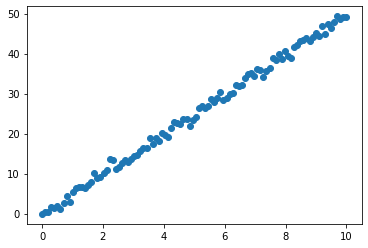

In [8]:
x = np.linspace(0,10,100)
y = 5*x + np.random.normal(0,1,100)
plt.scatter(x,y)
X = x.reshape(100,1)
w_ols = np.linalg.inv(X.T @ X) @ (X.T @y)
print(w_ols)

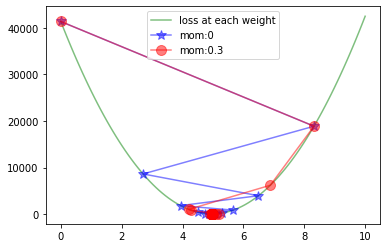

In [9]:
#Exercise: Explore the role of momentum and its interaction with learning rate and batch size
# estimate with lo/hi momentum
mom_lo=0
mom_hi=0.3

### START CODE HERE ###
#other hyperparams (play around with these to see their effect)
lr = 0.0005 # try 0.0005 and 0.0001
bs = 100 # try 10 and 100

# calculate
weights_lo, gradients_lo, costs_lo = lr_gd_mom(X,y,
              eta=lr,
              mom=mom_lo,
              batch_size=bs,
              epochs=100,
              weights_only=False,
              verbose=False)

weights_hi, gradients_hi, costs_hi = lr_gd_mom(X,y,
          eta=lr,
          mom=mom_hi,
          batch_size=bs,
          epochs=100,
          weights_only=False,
          verbose=False)

# plot
losses = [0.5*np.sum((y-x*w)**2) for w in np.linspace(0,10,100)]
plt.plot(x,losses,label='loss at each weight',alpha=0.5,color='green')

plt.plot(weights_lo,costs_lo,marker='*',alpha=0.5,label=f'mom:{mom_lo}',color='blue',ms=10)
plt.plot(weights_hi,costs_hi,marker='o',alpha=0.5,label=f'mom:{mom_hi}',color='red',ms=10)
plt.legend()
plt.show()
### END CODE HERE ###


## Conceptual questions

**@Exercise: Describe how momentum helps learning the parameters when:**

**A) The learning rate is small**

*@@@ START MARKDOWN ANSWER HERE @@@*

The learning rate is too small in cases where we could be taking larger steps down the slope. Momentum counteracts this as the velocity update is larger than the gradient itself in those cases. You can visualize this in the example above by setting the learning rate to 0.0001, we see that with momentum the weights descend down the slope faster.
You can also think about it like this: if we are moving in the same direction as before, we are more confident that we are moving in the right direction, and hence increase our step size.


*@@@ END MARKDOWN ANSWER HERE @@@*

**B) The learning rate is large**

*@@@ START MARKDOWN ANSWER HERE @@@*

The learning rate is (too) large in cases when the updates overshoot the actual optimal weights. Momentum counteracts this overshooting effect as the velocity update is smaller than the gradient itself in those cases. You can visualize this in the example above by setting the learning rate to 0.0005, we see that with momentum the weights descend down the slope faster, because it doesn't keep bouncing back and forth around the true minimum.
You can also think about it like this: if we are moving in a different direction than before, we are less  confident that we are moving in the right direction, and hence decrease our step size.


*@@@ END MARKDOWN ANSWER HERE @@@*

**C) The gradient is noisy (e.g. smaller batch size)**

*@@@ START MARKDOWN ANSWER HERE @@@*

The gradient is noisy when our batch size decreases. Momentum counteracts these noisy gradients by taking the average of many noisy gradients and thus hopefully getting us closer to the true gradient. You can visualize this in the example above by setting the batch size to 10.


*@@@ END MARKDOWN ANSWER HERE @@@*

# RMSPROP

## Intuition

A different problem we have seen with 'vanilla' SGD is that some parameters are learned more quickly than others. I.e. after a number of epochs some parameters hardly change anymore, while others are still steadily in/decreasing in value. We've seen this in our recap above as well.

The problem with a fixed learning rate for all weights is that it can be too low for one and too high for another. Remember that, ceteris paribus, if the gradients are small (large) then we might want to have a larger (smaller) learning rate. Hence it makes sense to scale the learning rate for each weight to be inversely proportional to the squared derivative of the loss wrt that weight.

There are many different implementations of this concept, today we will show you *RMSProp* or Root Mean Squared Propagation. Which takes the exponentially decaying moving average of squared gradients. Empirically it has been shown to work well, and it is currently (one of) the go-to optimization methods for deep learning practicioners.

**Algorithm -- RMSProp:**
* Require: intialized weights $\mathbf{w}_0$
* Require: learning rate $\eta$
* Require: RMSProp parameter rho ($\rho$)
* For $i$ in iterations:
    * Sample a batch from the training set: $\mathbf{x, y}$
    * Estimate the gradient for this batch at the current weights: $g_i = \frac{dE}{d\mathbf{w}_{i}}$
    * **NEW:** Take the exponentially decaying moving average (EDMA) of the squared gradients: $r_i = \rho * r_{i-1} + (1-\rho)(g_i \odot g_i)$
    * Update the weights: $\mathbf{w}_{i+1} = \mathbf{w}_i - \frac{\eta}{\sqrt{r_i+\epsilon}} g$
    
where:
* $\epsilon$ is some near-zero offset to avoid dividing by zero (e.g. $10^{-6})$
* $\odot$ is the hadamard prodcut (element-wise multiplication)


## Implementation

In [10]:
#Exercise: Add momentum and rmsprop to sgd
def lr_rmsprop(phi,t,eta, rho, mom, batch_size, epochs, weights_only=False, verbose=False):
    """    
    Purpose:
        Stochastic Gradient Descent with momentum and RMSProp
    Inputs:
        phi        (n,k) matrix, design matrix
        t          (n,) vector, target variable
        eta        double, learning rate
        rho        double, RMSProp parameter
        mom        double, momentum parameter
        batch_size integer, length of subset of data in one batch
        epochs     integer, number of epochs, that is the number of runs through the entire dataset
        weights_only: boolean, if True then only the last, presumably best, weights are returned
        verbose:      boolean, if True then print cost and r squared at end of each epoch
    Output:
    if weights_only=True:
        weights    (k,) vector, last weights
    
    if weights_only=False:
        weights    (total_iters,k) matrix, weight values for each epoch
        gradients  (total_iters,k) matrix, gradient values for each epoch
        costs      (total_iters,) vector, loss values for each epoch
    """
    # intialize
    n = t.shape[0]
    w = np.zeros(phi.shape[1])
    edma_dEdw = None # exponentially weighted moving average of gradients
    edma_sq_dEdw = None # the exponentially weighted moving average of SQUARED gradients
    
    
    # calc iters per epoch given a batch size
    iters_per_epoch = (n-1)//batch_size + 1
    total_iters = epochs * iters_per_epoch
    
    # result arrays
    if not weights_only:
        weights = np.zeros((total_iters,phi.shape[1]))
        gradients = np.zeros((total_iters,phi.shape[1]))
        costs = np.zeros((total_iters))

    for epoch in range(int(epochs)):
        # shuffle the dataset
        shuffled_index = np.random.permutation(n)
        phi_s = phi[shuffled_index]
        t_s = t[shuffled_index]
        for i in range(iters_per_epoch):
            # set idx for result arrays
            idx = epoch * iters_per_epoch + i
            # get batch
            phi_b = phi_s[i*batch_size:(i+1)*batch_size,:]
            t_b = t_s[i*batch_size:(i+1)*batch_size]
            
            # calc gradient
            y_b = phi_b@w        
            dEdw = -1*(t_b-y_b).T@phi_b
            
            # momentum update rule:
            if edma_dEdw is None:
                edma_dEdw = dEdw
            else:
                edma_dEdw = mom*edma_dEdw + (1-mom)*dEdw
                
            # rmsprop update rule:
            ### START CODE HERE ###
            if isinstance(rho,float): # check if we want to do rmsprop
                if edma_sq_dEdw is None: # special case if there are no previous squared gradients
                    edma_sq_dEdw = dEdw**2
                else:
                    edma_sq_dEdw = rho*edma_sq_dEdw + (1-rho)*dEdw**2 # <---------- CODE HERE
                
                adj_eta = eta/(np.sqrt(edma_sq_dEdw)+1e-06)# <---------- CODE HERE
            else:
                adj_eta = eta  
            ### END CODE HERE ###
            
            # store
            if not weights_only:
                weights[idx,:] = w
                costs[idx] = 0.5*np.sum((t-phi@w)**2) #note this cost is based on the entire dataset
                gradients[idx,:] = dEdw

            # update parameters
            w = w - adj_eta*edma_dEdw
            ### END CODE HERE ###
        
        # print
        if verbose:
            r2 = r2_score(t,y)
            print(f'epoch: {epoch}: E:{E:.2f}, R2:{r2:.2f}')    
            
    if weights_only:
        return w
    else:
        return weights, gradients, costs

## Two dimensional example

We now create a two dimensional dataset, where the second feature is **sparse**, i.e., it has many values (near-)zero and only a few that are large.
Here we will see that vanilla SGD does not learn the parameter of the sparse feature very quickly. 

the true optimal parameters for our data are: [ 5.00980337 49.67132462]


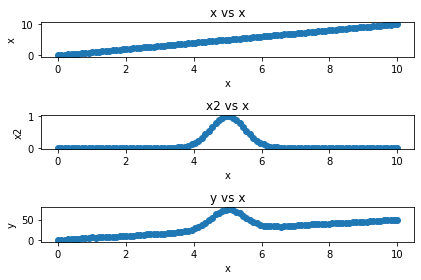

In [11]:
# two dimensional problem
x = np.linspace(0,10,100)
x2 = gaussian_basis_function(x,5,0.5)
y = 5*x +50*x2 + np.random.normal(0,0.5,100)
X = np.column_stack((x,x2))
w_ols = np.linalg.inv(X.T @ X) @ (X.T @y)
print(f'the true optimal parameters for our data are: {w_ols}')

fig = plt.figure()
ax1 = fig.add_subplot(3,1,1)
ax1.scatter(x,x)
ax1.set_xlabel('x')
ax1.set_ylabel('x')
ax1.set_title('x vs x')

ax2 = fig.add_subplot(3,1,2)
ax2.scatter(x,x2)
ax2.set_xlabel('x')
ax2.set_ylabel('x2')
ax2.set_title('x2 vs x')


ax3 = fig.add_subplot(3,1,3)
ax3.scatter(x,y)
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_title('y vs x')

fig.tight_layout()

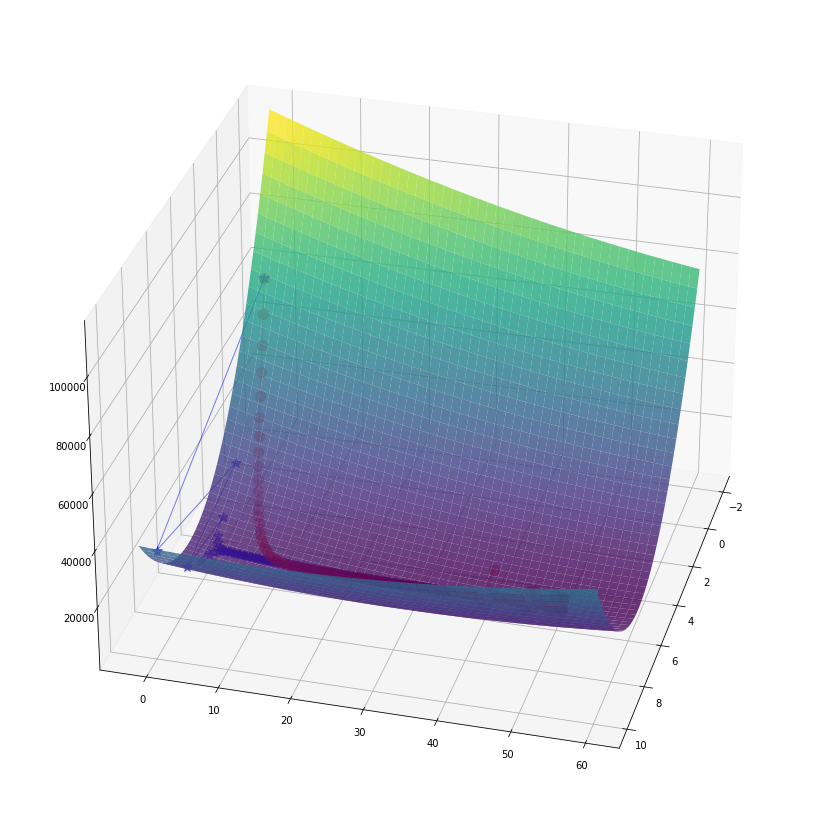

In [12]:
# estimate with lo/hi rmsprop
rho_lo=False
eta_lo=0.0005

rho_hi=0.9
eta_hi=0.5

### START CODE HERE ###
#other hyperparams (play around with these to see their effect)
mom = 0. # try 0 and 0.3
bs = 100 # try 10 and 100
### END CODE HERE ###

# calc
weights_lo, gradients_lo, costs_lo = lr_rmsprop(X,y,
              eta=eta_lo,
              rho=rho_lo,
              mom=mom,
              batch_size=bs,
              epochs=300,
              weights_only=False,
              verbose=False)

weights_hi, gradients_hi, costs_hi = lr_rmsprop(X,y,
          eta=eta_hi,
          rho=rho_hi,
          mom=mom,
          batch_size=bs,
          epochs=300,
          weights_only=False,
          verbose=False)

# create the loss curve
def loss_wrt_wgts(w1, w2):
    w = np.array([w1,w2])
    y_hat = X@w
    return 0.5*np.sum((y-y_hat)**2)

w0_range = np.linspace(-2, 10, 50)
w1_range = np.linspace(-2, 60, 50)
mesh = np.meshgrid(w0_range, w1_range)
loss_wgts = np.vectorize(loss_wrt_wgts)
loss_mesh = loss_wgts(*mesh)

# 3d plot the loss curve and the weights
fig = plt.figure(figsize=(15,15))
ax = fig.gca(projection='3d')
ax.plot_surface(*mesh, loss_mesh, cmap='viridis', alpha=0.8)
ax.plot3D(weights_lo[:,0], weights_lo[:,1], costs_lo, c='b', marker='*', markersize=10, 
           linewidth=1,alpha=0.5)
ax.plot3D(weights_hi[:,0], weights_hi[:,1], costs_hi, c='r', marker='o', markersize=10, 
           linewidth=1,alpha=0.3)
ax.view_init(elev=30,azim=15)

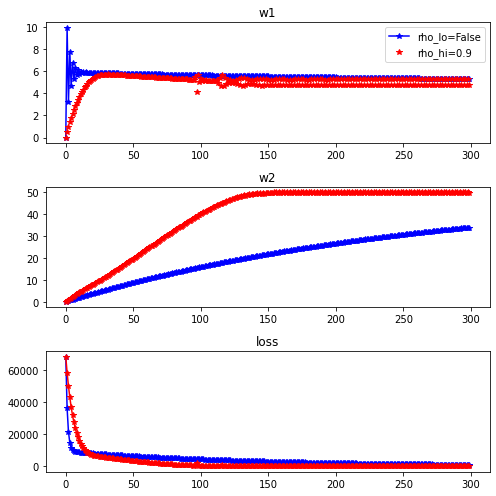

In [13]:
# 2d plots
fig = plt.figure(figsize=(7,7))
ax1 = fig.add_subplot(3,1,1)
ax1.plot(weights_lo[:,0],'b*-',label=f'rho_lo={rho_lo}')
ax1.plot(weights_hi[:,0],'r*',label=f'rho_hi={rho_hi}')
ax1.set_title('w1')
ax1.legend()

ax2 = fig.add_subplot(3,1,2)
ax2.plot(weights_lo[:,1],'b*-')
ax2.plot(weights_hi[:,1],'r*-')
ax2.set_title('w2')

ax3 = fig.add_subplot(3,1,3)
ax3.plot(costs_lo,'b*-')
ax3.plot(costs_hi,'r*-')
ax3.set_title('loss')

fig.tight_layout()

## Conceptual questions

**@Exercise: Answer the following questions**

**A) Describe in your own words what it means that a feature is sparse**

*@@@ START MARKDOWN ANSWER HERE @@@*

Sparse features are those with (near-)zero values for most observations and non-zero values for only a few observations.

*@@@ END MARKDOWN ANSWER HERE @@@*

**B) How does sparsity (many feature values near zero) affect the estimated gradient?**

*@@@ START MARKDOWN ANSWER HERE @@@*

Sparse features have smaller gradients because of the many multiplications by zero in the gradient equation:

$$\frac{dE}{d\mathbf{w}} = - (\mathbf{t-y})^T \mathbf{\Phi}$$

Intuitively: The gradient describes how changing a weight will increase/decrease the overall loss. It then makes sense that changing a weight of a feature that is only relevant for a small number of features won't help to decrease the overall loss much.


*@@@ END MARKDOWN ANSWER HERE @@@*

**C) Describe in your own words why it might not be a good idea to explicitly define different learning rates for each weight, rather than scale with the squared gradient as done above.** 

*@@@ START MARKDOWN ANSWER HERE @@@*

As the number of features increase, the number of learnings rates that have to be set also increase. This means that the hyper parameter optimization problem becomes a larger problem on its own.


*@@@ END MARKDOWN ANSWER HERE @@@*

# Back to original data

We have explored the role of momentum and RMSProp in 1- and 2-dimensional situations respectively. Let us now return to our original dataset, at which we could not get to a good answer after 100,000 epochs (at batch_size=100).

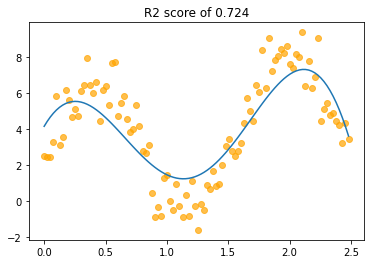

In [14]:
# Estimate with momentum
weights, gradients, costs = lr_rmsprop(phi_ex,t_ex,
          eta=0.005,
          rho=False,
          mom=0.9,
          batch_size=100,
          epochs=int(1e5),
          weights_only=False,
          verbose=False)

# Make final prediction
w = weights[-1]
y_ex = phi_ex@w
# plot first 1000 observations
plt.scatter(x_ex,t_ex,c='orange',alpha=0.7)
plt.plot(x_ex,y_ex)
r2 = r2_score(t_ex,y_ex)
plt.title(f'R2 score of {r2:.3f}')
plt.show()

Adding momentum already gets us closer to the true parameters! Note that we are using a larger learning rate than before. We could not use such a large gradient without momentum because it caused the loss to explode.

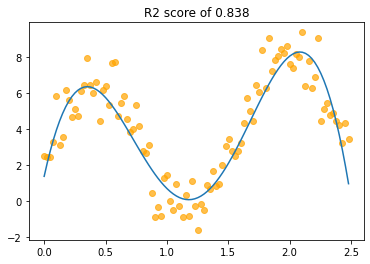

In [15]:
# Estimate with rmsprop
weights, gradients, costs = lr_rmsprop(phi_ex,t_ex,
          eta=1,
          rho=0.9,
          mom=0.9,
          batch_size=100,
          epochs=int(1e5),
          weights_only=False,
          verbose=False)

# Make final prediction
w = weights[-1]
y_ex = phi_ex@w
# plot first 1000 observations
plt.scatter(x_ex,t_ex,c='orange',alpha=0.7)
plt.plot(x_ex,y_ex)
r2 = r2_score(t_ex,y_ex)
plt.title(f'R2 score of {r2:.3f}')
plt.show()

In [16]:
weights.shape

(100000, 5)

Combining momentum with rmsprop gets us to (almost) the true parameters!

# Conclusion

Last week we have seen that learning the right parameters with gradient descent can take a long time. Today we have implemented two tricks to improve the learning speed: *momentum* and *RMSProp*. Finding the right optimization scheme to learn the weights is still an active area of ongoing research, and there are many other schemes out there.
